# DeepHit for Single Event

In this notebook we show an example of how we can fit a [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) model when we only have *one* event type.

If you are interested in **competing risks**, see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb) instead.

For a more verbose introduction to `pycox` see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [ ]:
!pip install torch &> /dev/null
!pip install pycox &> /dev/null
!pip install torchtuples &> /dev/null

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from statistics import mean
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
results = {
    'mae_gs_deepHit':[],
    'rmse_gs_deepHit':[],
    'r2_gs_deepHit':[],
    'pcc_gs_deepHit':[],
    'cindex_gs_deepHit':[],
    'y_exp_means_deepHit':[]
}

In [ ]:
#df = pd.read_excel('/content/drive/MyDrive/48hrstrue.xlsx')
df = pd.read_excel('/content/drive/MyDrive/Team 2 - News Spreading and Diffusion Models/code/Standardized Code/5 21 other models/15minfake.xlsx')

In [ ]:
df = df.drop(columns=['Unnamed: 0','fake(1)/real(0)'])

In [ ]:
#np.random.seed(1234)
#_ = torch.manual_seed(123)
_ = np.random.seed(1234)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [ ]:
df_train = df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.075)
df_train = df_train.drop(df_val.index)

In [ ]:
df_train.head()

,LABEL,time_elapsed,tie_strngth_influencer_persp,tie_strngth_follower_persp,average_time,count_night_posts,count_day_posts,count_weekday_posts,count_weekend_posts,post_time_perc,...,Objective,compound,neg,neu,pos,polarity,TFF,diff_con,deg_out,deg_in
0,1,4,27.659574,361.538462,0.0,0.560976,0.439024,0.731707,0.268293,0.002974,...,0.668382,-0.146073,0.108182,0.856273,0.035727,-1,5.483553,0.079058,0.000094,0.000017
1,1,4,12.500000,800.000000,0.0,0.285714,0.714286,0.714286,0.285714,-0.061224,...,0.709246,0.168644,0.064778,0.691778,0.243444,1,0.001916,0.024567,0.000000,0.000010
2,1,1,0.000000,0.000000,0.0,0.416667,0.583333,0.708333,0.291667,-0.006944,...,0.533457,0.224777,0.085617,0.583383,0.331021,1,5.904368,0.049373,0.000094,0.000016
3,1,27,700.000000,14.285714,0.0,0.105263,0.894737,0.736842,0.263158,-0.041551,...,0.622126,0.065570,0.106367,0.733944,0.159678,1,0.001484,0.037209,0.000000,0.000013
4,1,95,4.255319,9400.000000,0.0,0.583333,0.416667,0.833333,0.166667,0.013889,...,0.566893,0.153150,0.087667,0.765000,0.147333,1,0.003003,1.253165,0.000000,0.000006


In [ ]:
columnsToStandardize = df_train.columns.values.tolist()
type(columnsToStandardize)
columnsToStandardize.remove('LABEL')
columnsToStandardize.remove('time_elapsed')
print(columnsToStandardize)

['tie_strngth_influencer_persp', 'tie_strngth_follower_persp', 'average_time', 'count_night_posts', 'count_day_posts', 'count_weekday_posts', 'count_weekend_posts', 'post_time_perc', 'post_day_perc', 'stress', 'male_x', 'female_x', '<=18', '19-29', '30-39', '>=40', 'smog_index_x', 'num_propernouns_x', 'num_personalnouns_x', 'num_ppssessivenouns_x', 'num_adverb_x', 'num_verb_x', 'num_vbd_x', 'num_vbg_x', 'num_vbn_x', 'num_vbp_x', 'WC_x', 'WPS_x', 'i_x', 'shehe_x', 'focuspast_x', 'work_x', 'AllPunc_x', 'Exclam_x', 'Anger_x', 'Fear_x', 'Sadness_x', 'Surprise_x', 'Trust_x', 'neg_x', 'num_propernouns_y', 'num_personalnouns_y', 'num_ppssessivenouns_y', 'num_whpronoun_y', 'num_determinants_y', 'num_whdeterminants_y', 'num_adverb_y', 'num_verb_y', 'num_adj_y', 'num_vbg_y', 'num_vbn_y', 'num_vbp_y', 'lexical_diversity_y', 'WC_y', 'Tone_y', 'shehe_y', 'negemo_y', 'focuspast_y', 'work_y', 'Quote_y', 'Disgust_y', 'Surprise_y', 'neg_y', 'pagerank', 'similarity_news', 'similarity_y', 'Anger', 'Antic

## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [ ]:
cols_standardize = columnsToStandardize

#if binary then place in cols_leave
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
In this case `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

DeepHit is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [ ]:
# the num durations if from previous survival code from summer length of y_test, but here length of y_val
num_durations = 56
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['time_elapsed'].values, df['LABEL'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
y_test = labtrans.transform(*get_target(df_test))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [ ]:
y_val_len = len(y_val[0])
y_val_len

56

In [ ]:
train

(array([[-1.00429490e-01,  5.02472878e-01, -3.80969644e-02, ...,
         -1.31296277e-01,  2.15447116e+00,  7.03031540e-01],
        [-1.98755831e-01,  1.25748825e+00, -3.80969644e-02, ...,
         -1.47142425e-01, -5.07958353e-01,  5.53346425e-02],
        [-2.79831946e-01, -1.20083608e-01, -3.80969644e-02, ...,
         -1.39928713e-01,  2.15447116e+00,  5.95082045e-01],
        ...,
        [-2.79831946e-01, -1.20083608e-01, -3.80969644e-02, ...,
         -4.78491634e-02, -5.07958353e-01, -5.94023049e-01],
        [-2.79831946e-01, -1.20083608e-01, -3.80969644e-02, ...,
         -1.41945956e-02, -5.07958353e-01, -4.46215272e-01],
        [-2.79831946e-01, -1.20083608e-01,  2.62488098e+01, ...,
         -1.08796164e-01, -5.07958353e-01, -7.53456116e-01]], dtype=float32),
 (array([ 1,  1,  1,  2,  7, 13,  1,  2,  1,  4,  1,  1,  1,  1,  1,  1,  2,
          1,  3,  1,  1,  1,  5,  1,  1, 11,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  2,  1,  4,  1,  4,  3,  1,  1,  1,  1, 14,  1,

In [ ]:
print(len(y_val[0]))
print(len(y_test[0]))
print(len(y_train[0]))

print(len(x_val[0]))
print(len(x_test[0]))
print(len(x_train[0]))

56
186
690
84
84
84


In [ ]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

DeepHit has a loss that is a combination of a negative log-likelihood and a ranking loss. `alpha` is a parameter that controls the linear combination between the two, and `sigma` is a parameter used by the ranking loss. `alpha = 1` give a loss only containing the negative log-likelihood and `alpha = 0` give a pure ranking loss. Note that this is different than the original paper.

In [ ]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

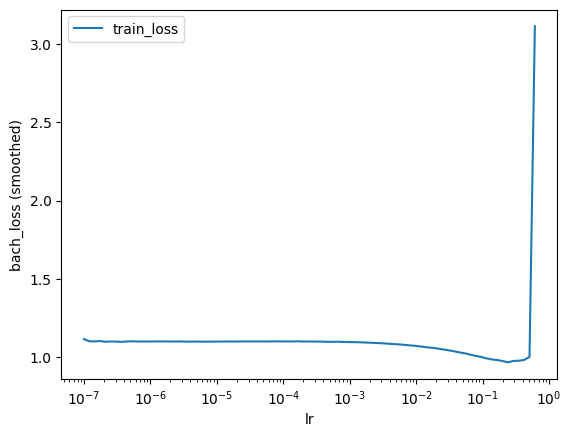

In [ ]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [ ]:
lr_finder.get_best_lr()

0.02420128264794396

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [ ]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [ ]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.0644,	val_loss: 1.0330
1:	[0s / 0s],		train_loss: 0.9676,	val_loss: 0.9865
2:	[0s / 0s],		train_loss: 0.9128,	val_loss: 0.9332
3:	[0s / 0s],		train_loss: 0.8578,	val_loss: 0.8777
4:	[0s / 0s],		train_loss: 0.8201,	val_loss: 0.8392
5:	[0s / 0s],		train_loss: 0.7779,	val_loss: 0.8001
6:	[0s / 0s],		train_loss: 0.7269,	val_loss: 0.7563
7:	[0s / 0s],		train_loss: 0.6915,	val_loss: 0.7035
8:	[0s / 0s],		train_loss: 0.6440,	val_loss: 0.6467
9:	[0s / 0s],		train_loss: 0.6047,	val_loss: 0.5956
10:	[0s / 0s],		train_loss: 0.5839,	val_loss: 0.5995
11:	[0s / 0s],		train_loss: 0.5372,	val_loss: 0.6024
12:	[0s / 0s],		train_loss: 0.5177,	val_loss: 0.5941
13:	[0s / 0s],		train_loss: 0.4917,	val_loss: 0.6649
14:	[0s / 0s],		train_loss: 0.4408,	val_loss: 0.7756
15:	[0s / 0s],		train_loss: 0.4306,	val_loss: 0.9040
16:	[0s / 0s],		train_loss: 0.3813,	val_loss: 1.0862
17:	[0s / 0s],		train_loss: 0.3755,	val_loss: 1.3321
18:	[0s / 0s],		train_loss: 0.3696,	val_loss: 1.2984
19:

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [ ]:
surv = model.predict_surv_df(x_test)
surv

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,181,182,183,184,185
0.000000,0.994472,0.909138,0.954971,0.995422,0.988066,0.986178,0.935074,0.993776,0.994835,0.993546,...,0.993859,0.994940,0.947760,0.997176,0.980572,0.999461,0.977390,0.994780,0.998077,0.995505
14.545455,0.724193,0.756389,0.916516,0.688687,0.793451,0.985136,0.681681,0.992034,0.787457,0.992738,...,0.542057,0.654120,0.803642,0.699354,0.932533,0.789820,0.869918,0.744056,0.740937,0.807339
29.090909,0.637301,0.735677,0.891173,0.635074,0.664639,0.980466,0.634766,0.987266,0.659407,0.985787,...,0.466206,0.599447,0.712049,0.626880,0.844513,0.664679,0.806356,0.673179,0.633586,0.665817
43.636364,0.550462,0.672773,0.868184,0.526456,0.605291,0.978505,0.578345,0.986377,0.589665,0.984941,...,0.390976,0.516600,0.690517,0.535338,0.828250,0.524125,0.747192,0.565152,0.511367,0.495034
58.181818,0.531406,0.650811,0.844530,0.501020,0.579776,0.949159,0.562959,0.976228,0.563681,0.933148,...,0.369153,0.498451,0.668711,0.513253,0.814865,0.485720,0.729511,0.543307,0.480871,0.479047
72.727273,0.492053,0.646517,0.838611,0.476114,0.538760,0.947668,0.536812,0.975605,0.522341,0.932418,...,0.341919,0.474051,0.657647,0.485422,0.795113,0.458101,0.680323,0.513136,0.441603,0.468790
87.272727,0.475214,0.634752,0.825213,0.458144,0.522963,0.944068,0.525460,0.971385,0.502907,0.919846,...,0.333405,0.455184,0.638446,0.463005,0.775213,0.422505,0.659221,0.492198,0.421905,0.444736
101.818182,0.391233,0.568433,0.808646,0.403387,0.488086,0.943181,0.468384,0.970769,0.439461,0.919166,...,0.315839,0.396871,0.604692,0.395866,0.757265,0.349355,0.623913,0.422577,0.376345,0.438504
116.363636,0.373235,0.561916,0.800831,0.381911,0.463749,0.941597,0.445542,0.969343,0.406359,0.918237,...,0.285925,0.374360,0.595515,0.366746,0.746209,0.327380,0.600683,0.402941,0.358887,0.421983
130.909091,0.350097,0.555559,0.787154,0.355175,0.457136,0.936103,0.434901,0.965062,0.390405,0.912461,...,0.282738,0.351357,0.583097,0.339907,0.725206,0.289650,0.588441,0.378653,0.342959,0.418469


In [ ]:
#make it reflect just 48
surv48 = surv.loc[:,0:56]
surv48TimeArray = surv48.columns.to_list()
timeArray = surv48TimeArray

In [ ]:
#Find nearest value in an array
def find_nearest_time(array, value):
    if value==0:
        return 0
    else:
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

#Return the survival function value for given index (user) and specified time
def Survival(predictSurv,timeArray,i,x):
    #Save the times array for the given survival function as integers
    times = timeArray
    #find the index of the time step specified
    if x<=times[-2]:
        t = np.where(times==find_nearest_time(times,x))[0][0]

    else:
        t=np.where(times==find_nearest_time(times,192))[0][0]

    #return the survival function value at the index of specified time
    return predictSurv[t]

In [ ]:
#either y_test or y_val

exp_times_gs_deepHit = []
for i in [*range(0,y_val_len,1)]:
        st=[]
        for x in [*range(1,y_val_len+1,1)]:
            st.append((x+1)*(Survival(surv,timeArray,i,x)-Survival(surv,timeArray,i,x+1)))

        exp = sum(st)+(y_val_len+1)*(Survival(surv,timeArray,i,y_val_len))

y_exp_mean = mean(exp)
results['y_exp_means_deepHit'].append(y_exp_mean)
y_true=y_val[0]

results['rmse_gs_deepHit'].append(np.sqrt(mean_squared_error(y_true, exp)))

In [ ]:
print(y_true.shape)
print(exp.shape)

(56,)
(56,)


In [ ]:
exp

0.000000      55.736511
14.545455     48.185177
29.090909     44.060818
43.636364     40.571815
58.181818     39.044701
72.727273     37.716221
87.272727     36.725201
101.818182    34.450630
116.363636    33.492004
130.909091    32.593544
145.454545    32.156013
160.000000    31.623760
174.545455    31.227522
189.090909    30.476494
203.636364    29.898384
218.181818    29.502235
232.727273    29.093918
247.272727    28.692030
261.818182    28.293568
276.363636    27.792309
290.909091    27.402435
305.454545    27.034721
320.000000    26.532541
334.545455    26.190641
349.090909    25.802237
363.636364    25.372921
378.181818    24.924059
392.727273    24.539270
407.272727    24.224529
421.818182    23.750740
436.363636    23.364990
450.909091    22.890659
465.454545    22.375441
480.000000    21.845163
494.545455    21.158302
509.090909    20.694630
523.636364    20.088173
538.181818    19.628399
552.727273    19.156843
567.272727    18.665613
581.818182    18.248409
596.363636    17

In [ ]:
y_true

array([ 1, 55, 55, 55, 55, 55,  1, 55, 55,  6, 55, 55,  1, 55, 55,  4,  1,
       55,  1, 55,  1, 55,  2, 55,  1,  9,  3,  2,  1, 55,  1, 55,  3, 55,
        3,  4,  1,  1, 55, 55, 55,  1,  1, 55,  1, 55, 55, 55,  1, 55,  1,
        7,  3, 55,  1,  1])

In [ ]:
results['rmse_gs_deepHit']

[26.478858089161417]

In [ ]:
#NRMSE
mean(results['rmse_gs_deepHit'])/mean(results['y_exp_means_deepHit'])

0.4577290023272374

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [ ]:
ev.concordance_td('antolini')

0.5106333616889644